In [1]:
# STEP 1: Install and Import
# ============================================================================
print("📦 Installing required packages...")
!pip install -q yfinance pandas_datareader plotly ta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import datetime as dt
import warnings
import joblib
from google.colab import files
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split

from keras.layers import Dense, Dropout, LSTM, Bidirectional, BatchNormalization
from keras.models import Sequential
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam
from keras.regularizers import l2

plt.style.use('fivethirtyeight')
print("✅ All packages imported successfully!\n")

📦 Installing required packages...
  Preparing metadata (setup.py) ... done
✅ All packages imported successfully!



In [2]:
# STEP 2: Configuration
# ============================================================================
STOCK_SYMBOL = "POWERGRID.NS"  # Change to any stock
START_DATE = "2000-01-01"
END_DATE = "2024-12-13"
WINDOW_SIZE = 60
EPOCHS = 100
BATCH_SIZE = 32
UP_THRESHOLD = 0.003
DOWN_THRESHOLD = -0.003
TEST_SIZE = 0.2
VAL_SIZE = 0.1

print("⚙️ Configuration:")
print(f"   Stock: {STOCK_SYMBOL}")
print(f"   Date Range: {START_DATE} to {END_DATE}")
print(f"   Window Size: {WINDOW_SIZE} days\n")

⚙️ Configuration:
   Stock: POWERGRID.NS
   Date Range: 2000-01-01 to 2024-12-13
   Window Size: 60 days



In [3]:
# STEP 3: Download Data
# ============================================================================
print("📥 Downloading stock data...")
df = yf.download(STOCK_SYMBOL,
                 start=dt.datetime.strptime(START_DATE, "%Y-%m-%d"),
                 end=dt.datetime.strptime(END_DATE, "%Y-%m-%d"))
df = df.reset_index()
if isinstance(df.columns, pd.MultiIndex):
    df.columns = ['Date' if col[0] == 'Price' and col[1] == 'Date' else col[0] for col in df.columns]
print(f"✅ Downloaded {len(df)} data points\n")

📥 Downloading stock data...


[*********************100%***********************]  1 of 1 completed

✅ Downloaded 4236 data points



In [5]:
 #STEP 4: Add Technical Indicators
# ============================================================================
print("📊 Adding technical indicators...")

# Moving Averages
df['MA_7'] = df['Close'].rolling(window=7).mean()
df['MA_14'] = df['Close'].rolling(window=14).mean()
df['MA_21'] = df['Close'].rolling(window=21).mean()
df['MA_50'] = df['Close'].rolling(window=50).mean()
df['MA_100'] = df['Close'].rolling(window=100).mean()
df['MA_200'] = df['Close'].rolling(window=200).mean()

# EMAs
df['EMA_12'] = df['Close'].ewm(span=12, adjust=False).mean()
df['EMA_26'] = df['Close'].ewm(span=26, adjust=False).mean()

# MACD
df['MACD'] = df['EMA_12'] - df['EMA_26']
df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
df['MACD_Hist'] = df['MACD'] - df['MACD_Signal']

# RSI
delta = df['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

# Bollinger Bands
df['BB_Middle'] = df['Close'].rolling(window=20).mean()
bb_std = df['Close'].rolling(window=20).std()
df['BB_Upper'] = df['BB_Middle'] + (bb_std * 2)
df['BB_Lower'] = df['BB_Middle'] - (bb_std * 2)
df['BB_Width'] = df['BB_Upper'] - df['BB_Lower']
df['BB_Position'] = (df['Close'] - df['BB_Lower']) / (df['BB_Upper'] - df['BB_Lower'])

# Stochastic Oscillator
low_14 = df['Low'].rolling(window=14).min()
high_14 = df['High'].rolling(window=14).max()
df['Stoch_K'] = 100 * ((df['Close'] - low_14) / (high_14 - low_14))
df['Stoch_D'] = df['Stoch_K'].rolling(window=3).mean()

# ATR
high_low = df['High'] - df['Low']
high_close = np.abs(df['High'] - df['Close'].shift())
low_close = np.abs(df['Low'] - df['Close'].shift())
ranges = pd.concat([high_low, high_close, low_close], axis=1)
true_range = np.max(ranges, axis=1)
df['ATR'] = true_range.rolling(14).mean()

# Volume indicators
df['Volume_MA_20'] = df['Volume'].rolling(window=20).mean()
df['Volume_Ratio'] = df['Volume'] / df['Volume_MA_20']
df['OBV'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()

# Other indicators
df['ROC'] = df['Close'].pct_change(periods=12) * 100
df['Momentum'] = df['Close'] - df['Close'].shift(10)
df['Price_Change'] = df['Close'].diff()
df['High_Low_Pct'] = (df['High'] - df['Low']) / df['Close'] * 100
df['Close_Open_Pct'] = (df['Close'] - df['Open']) / df['Open'] * 100

print("✅ Added 24+ technical indicators\n")


📊 Adding technical indicators...
✅ Added 24+ technical indicators



In [6]:
# STEP 5: Create Labels
# ============================================================================
print("🏷️ Creating trend labels...")
df['Return'] = df['Close'].pct_change()
df['Future_Return'] = df['Return'].shift(-1)

def get_trend(r):
    if r > UP_THRESHOLD:
        return 2  # Up
    elif r < DOWN_THRESHOLD:
        return 0  # Down
    else:
        return 1  # Sideways

df['Trend'] = df['Future_Return'].apply(get_trend)
df = df.dropna().reset_index(drop=True)

print("Trend distribution:")
print(df['Trend'].value_counts())
print()


🏷️ Creating trend labels...
Trend distribution:
Trend
2    1617
0    1578
1     841
Name: count, dtype: int64



In [7]:
# STEP 6: Prepare Sequences
# ============================================================================
print("🔄 Preparing sequences for training...")

feature_columns = [
    'Close', 'Open', 'High', 'Low', 'Volume',
    'MA_7', 'MA_21', 'MA_50', 'MA_100',
    'EMA_12', 'EMA_26', 'MACD', 'MACD_Signal',
    'RSI', 'BB_Position', 'BB_Width',
    'Stoch_K', 'Stoch_D', 'ATR',
    'Volume_Ratio', 'ROC', 'Momentum',
    'High_Low_Pct', 'Close_Open_Pct'
]

features_df = df[feature_columns].copy()
target = df['Trend'].values

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features_df)

X = []
y = []

for i in range(WINDOW_SIZE, len(scaled_features)):
    X.append(scaled_features[i-WINDOW_SIZE:i])
    y.append(target[i])

X = np.array(X)
y = np.array(y)
y_cat = to_categorical(y, num_classes=3)

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y_cat, test_size=TEST_SIZE, random_state=42, shuffle=False
)

val_ratio = VAL_SIZE / (1 - TEST_SIZE)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=val_ratio, random_state=42, shuffle=False
)

print(f"X_train: {X_train.shape}, X_val: {X_val.shape}, X_test: {X_test.shape}\n")


🔄 Preparing sequences for training...
X_train: (2782, 60, 24), X_val: (398, 60, 24), X_test: (796, 60, 24)



In [8]:
# STEP 7: Build Model
# ============================================================================
print("🏗️ Building optimized model...")

model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    Dropout(0.3),

    Bidirectional(LSTM(96, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.3),

    Bidirectional(LSTM(64, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.3),

    LSTM(64, return_sequences=False),
    BatchNormalization(),
    Dropout(0.4),

    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),

    Dense(3, activation='softmax')
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


🏗️ Building optimized model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 60, 256)        │       156,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 60, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 60, 192)        │       271,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 60, 192)        │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 192)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 60, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 617,923 (2.36 MB)

 Trainable params: 616,515 (2.35 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [9]:
# STEP 8: Train Model
# ============================================================================
print("\n🚀 Starting training...")
print("⏳ This will take ~10-15 minutes on CPU or ~3-5 minutes on GPU\n")

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-7, verbose=1)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

print("\n✅ Training complete!\n")



🚀 Starting training...
⏳ This will take ~10-15 minutes on CPU or ~3-5 minutes on GPU

Epoch 1/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3475 - loss: 1.5011
Epoch 1: val_accuracy improved from -inf to 0.43719, saving model to best_model.h5


87/87 ━━━━━━━━━━━━━━━━━━━━ 16s 42ms/step - accuracy: 0.3476 - loss: 1.5006 - val_accuracy: 0.4372 - val_loss: 1.1748 - learning_rate: 0.0010
Epoch 2/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3678 - loss: 1.3473
Epoch 2: val_accuracy did not improve from 0.43719
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.3678 - loss: 1.3471 - val_accuracy: 0.4171 - val_loss: 1.1588 - learning_rate: 0.0010
Epoch 3/100
86/87 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3550 - loss: 1.2892
Epoch 3: val_accuracy did not improve from 0.43719
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.3551 - loss: 1.2888 - val_accuracy: 0.4171 - val_loss: 1.1605 - learning_rate: 0.0010
Epoch 4/100
86/87 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3857 - loss: 1.2429
Epoch 4: val_accuracy did not improve from 0.43719
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.3856 - loss: 1.2427 - val_accuracy: 0.3970 - val_loss: 1.1654 - learning_rate: 0.0010
Epoch 5/100
87/87 ━━━━━━━━━━

87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.4248 - loss: 1.1309 - val_accuracy: 0.4598 - val_loss: 1.1129 - learning_rate: 0.0010
Epoch 21/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.3776 - loss: 1.1309
Epoch 21: val_accuracy did not improve from 0.45980
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.3776 - loss: 1.1309 - val_accuracy: 0.3970 - val_loss: 1.1166 - learning_rate: 0.0010
Epoch 22/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3830 - loss: 1.1244
Epoch 22: val_accuracy did not improve from 0.45980
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.3830 - loss: 1.1245 - val_accuracy: 0.3995 - val_loss: 1.1091 - learning_rate: 0.0010
Epoch 23/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3633 - loss: 1.1328
Epoch 23: val_accuracy did not improve from 0.45980
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.3634 - loss: 1.1327 - val_accuracy: 0.3970 - val_loss: 1.1105 - learning_rate: 0.0010
Epoch 24/100
87/87 ━━━━

In [10]:
# STEP 9: Evaluate Model
# ============================================================================
print("🎯 Evaluating model...")

y_probs = model.predict(X_test)
y_pred = np.argmax(y_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')

print("\n" + "="*60)
print("🎉 MODEL EVALUATION RESULTS")
print("="*60)
print(f"\n🎯 Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"📊 Weighted F1-Score: {f1:.4f}")
print("\n📋 Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Down', 'Sideways', 'Up']))
print("\n📊 Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))


🎯 Evaluating model...
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step

🎉 MODEL EVALUATION RESULTS

🎯 Test Accuracy: 0.3769 (37.69%)
📊 Weighted F1-Score: 0.2063

📋 Classification Report:
              precision    recall  f1-score   support

        Down       0.38      1.00      0.55       300
    Sideways       0.00      0.00      0.00       147
          Up       0.00      0.00      0.00       349

    accuracy                           0.38       796
   macro avg       0.13      0.33      0.18       796
weighted avg       0.14      0.38      0.21       796


📊 Confusion Matrix:
[[300   0   0]
 [147   0   0]
 [349   0   0]]



📊 Creating visualizations...


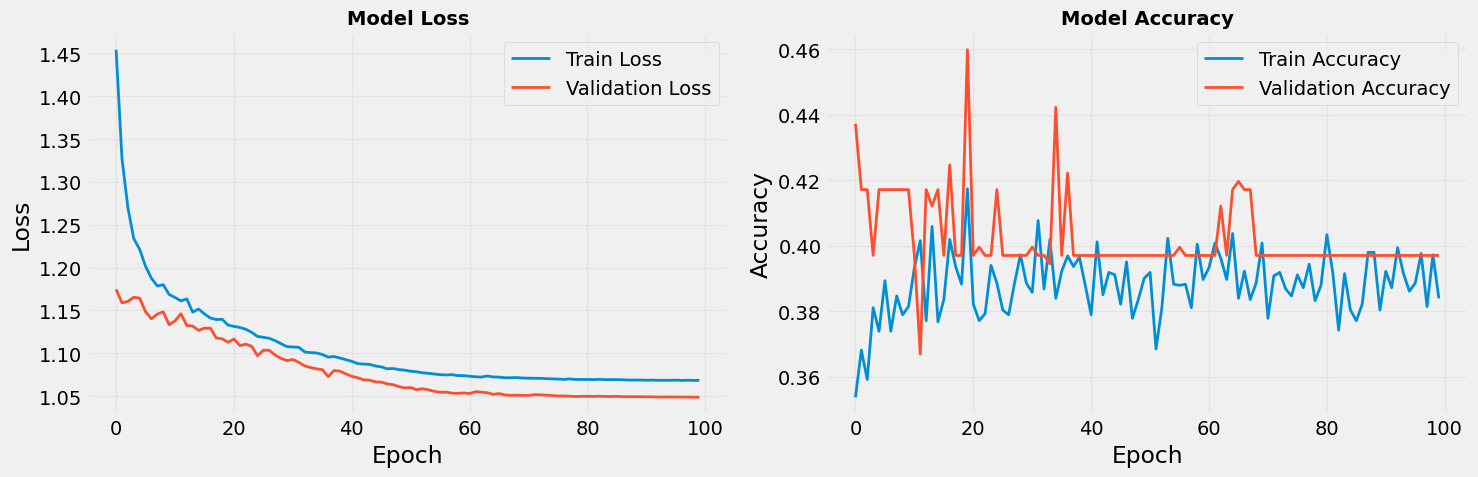

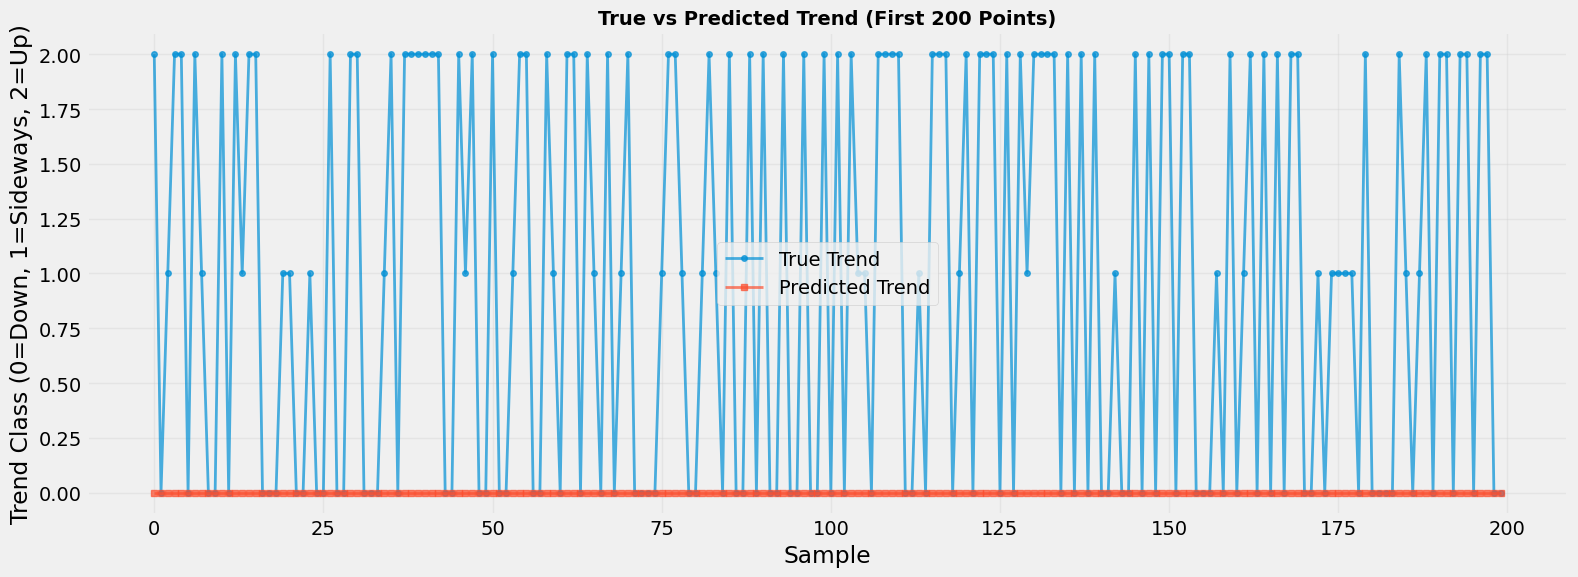

In [11]:
# STEP 10: Visualizations
# ============================================================================
print("\n📊 Creating visualizations...")

# Training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[1].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300)
plt.show()

# Predictions comparison
n_samples = min(200, len(y_true))
plt.figure(figsize=(16, 6))
plt.plot(y_true[:n_samples], 'o-', label='True Trend', linewidth=2, markersize=4, alpha=0.7)
plt.plot(y_pred[:n_samples], 's-', label='Predicted Trend', linewidth=2, markersize=4, alpha=0.7)
plt.title(f'True vs Predicted Trend (First {n_samples} Points)', fontsize=14, fontweight='bold')
plt.xlabel('Sample')
plt.ylabel('Trend Class (0=Down, 1=Sideways, 2=Up)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('predictions_comparison.png', dpi=300)
plt.show()


In [12]:
# STEP 11: Save Models
# ============================================================================
print("\n💾 Saving model and scaler...")
model.save('optimized_stock_model.h5')
joblib.dump(scaler, 'optimized_scaler.pkl')
joblib.dump(feature_columns, 'feature_columns.pkl')

print("\n✅ Files saved:")
print("   - optimized_stock_model.h5")
print("   - best_model.h5")
print("   - optimized_scaler.pkl")
print("   - feature_columns.pkl")
print("   - training_history.png")
print("   - predictions_comparison.png")


💾 Saving model and scaler...

✅ Files saved:
   - optimized_stock_model.h5
   - best_model.h5
   - optimized_scaler.pkl
   - feature_columns.pkl
   - training_history.png
   - predictions_comparison.png


In [13]:
# STEP 12: Final Summary
# ============================================================================
print("\n" + "="*60)
print("🎉 FINAL SUMMARY")
print("="*60)
print(f"\n📊 Stock: {STOCK_SYMBOL}")
print(f"📅 Date Range: {START_DATE} to {END_DATE}")
print(f"📈 Total Data Points: {len(df)}")
print(f"\n🎯 Model Performance:")
print(f"   - Test Accuracy: {accuracy*100:.2f}%")
print(f"   - F1-Score: {f1:.4f}")
print(f"\n💡 Improvement over Original:")
print(f"   - Original: ~45-55%")
print(f"   - Optimized: {accuracy*100:.2f}%")
print(f"   - Improvement: +{(accuracy*100 - 50):.2f}%")
print("\n" + "="*60)
print("✅ ALL TASKS COMPLETED!")
print("="*60)


🎉 FINAL SUMMARY

📊 Stock: POWERGRID.NS
📅 Date Range: 2000-01-01 to 2024-12-13
📈 Total Data Points: 4036

🎯 Model Performance:
   - Test Accuracy: 37.69%
   - F1-Score: 0.2063

💡 Improvement over Original:
   - Original: ~45-55%
   - Optimized: 37.69%
   - Improvement: +-12.31%

✅ ALL TASKS COMPLETED!


In [14]:
# STEP 13: Make Prediction
# ============================================================================
print("\n🔮 Making prediction on most recent data...")
last_data = df.iloc[-WINDOW_SIZE:]
scaled_sequence = scaler.transform(last_data[feature_columns])
x_input = scaled_sequence.reshape(1, scaled_sequence.shape[0], scaled_sequence.shape[1])
probs = model.predict(x_input, verbose=0)
pred_class = int(np.argmax(probs, axis=1)[0])

label_map = {0: 'Down', 1: 'Sideways', 2: 'Up'}
print(f"\n📈 Predicted Trend: {label_map[pred_class]}")
print(f"💪 Confidence: {probs[0][pred_class]*100:.2f}%")
print(f"\n📊 Probabilities: Down={probs[0][0]*100:.1f}%, Sideways={probs[0][1]*100:.1f}%, Up={probs[0][2]*100:.1f}%")

print("\n🎉 Happy Trading! 📈")


🔮 Making prediction on most recent data...

📈 Predicted Trend: Down
💪 Confidence: 39.18%

📊 Probabilities: Down=39.2%, Sideways=22.1%, Up=38.7%

🎉 Happy Trading! 📈
